In [65]:
import xarray as xr
import rioxarray as rxr
import sqlite3
import pandas as pd
import numpy as np

In [66]:
import shapely
from shapely.geometry import shape, mapping, Polygon

In [67]:
from cartopy import crs as ccrs

In [68]:
import os

# The variable is named ESMFMKFILE, and it must point to the esmf.mk file 

esmfmk = "/Users/akmoch/micromamba/envs/xa_dggs/lib/esmf.mk"
os.environ["ESMFMKFILE"] = esmfmk

In [69]:
hwsd_raster = "/Users/akmoch/dev/geodata/soc_test_analyse/hwsd/hwsd_world.tif"
hswd_data = "/Users/akmoch/dev/geodata/soc_test_analyse/hwsd/ex_data_copy1.gpkg"

In [70]:
import geopandas as gpd
# import xdggs
# import xagg as xa

import matplotlib as mpl
import matplotlib.pyplot as plt

In [71]:
hw_sd = xr.open_dataset(hwsd_raster, engine='rasterio')

In [72]:
hw_sd

<xarray.Dataset>
Dimensions:      (band: 1, x: 43200, y: 21600)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 90.0 89.99 89.98 89.97 ... -89.98 -89.99 -90.0
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

In [73]:
# gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea7h_3_hex_land_fix_single.gpkg")

# gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea7h_3.fgb")
# gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea3_generic_globe.gpkg")
# gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea3_generic_globe_zonal_hwsd.gpkg")

# gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea7h_4.fgb")
# gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea4_generic_globe.gpkg")
# gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea4_generic_globe_zonal_stats.gpkg")

# gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea7h_6_zoom1.fgb")
gdf_r3 = gpd.read_file("/Users/akmoch/dev/build/dggs_t1_presi/isea7h_6_zoom_stats.gpkg")


gdf_r3['name'] = pd.to_numeric(gdf_r3['name'], downcast='integer').astype(np.int64)
gdf_r3 = gdf_r3.set_index('name').rename(columns={'_majority': 'musoil_id'})
gdf_r3.index

Index([382321, 382322, 382665, 383009, 383010, 382666, 382323, 382667, 382324,
       382325,
       ...
       258552, 258551, 258207, 258206, 258549, 258550, 258894, 258893, 258548,
       258205],
      dtype='int64', name='name', length=21753)

In [74]:
from typing import Union, List
from shapely.geometry import mapping, Polygon, GeometryCollection
from shapely import affinity

# https://towardsdatascience.com/around-the-world-in-80-lines-crossing-the-antimeridian-with-python-and-shapely-c87c9b6e1513
# https://gist.github.com/PawaritL/ec7136c0b718ca65db6df1c33fd1bb11

def check_crossing(lon1: float, lon2: float, validate: bool = True):
    """
    Assuming a minimum travel distance between two provided longitude coordinates,
    checks if the 180th meridian (antimeridian) is crossed.
    """
    if validate and any(abs(x) > 180.0 for x in [lon1, lon2]):
        raise ValueError("longitudes must be in degrees [-180.0, 180.0]")   
    return abs(lon2 - lon1) > 180.0

def check_for_geom(geom):
    crossed = False
    p_init = geom.exterior.coords[0]

    for p in range(1, len(geom.exterior.coords)):
        px = geom.exterior.coords[p]
        # print(px)

        if check_crossing(p_init[0], px[0]):
            crossed = True
        p_init = px
    
    return crossed

In [75]:
gdf_r3['crossed'] = gdf_r3['geometry'].apply(check_for_geom)

In [76]:
gdf_r3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 21753 entries, 382321 to 258205
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   x             21753 non-null  float64 
 1   y             21753 non-null  float64 
 2   musoil_id     21753 non-null  int64   
 3   musoil_id_x   21753 non-null  float64 
 4   musoil_id_y   21753 non-null  float64 
 5   musoil_id_xy  21753 non-null  float64 
 6   _max          21753 non-null  float64 
 7   geometry      21753 non-null  geometry
 8   crossed       21753 non-null  bool    
dtypes: bool(1), float64(6), geometry(1), int64(1)
memory usage: 1.5 MB


In [77]:
gdf_r3 = gdf_r3.loc[~gdf_r3['crossed']].copy()
gdf_r3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 21753 entries, 382321 to 258205
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   x             21753 non-null  float64 
 1   y             21753 non-null  float64 
 2   musoil_id     21753 non-null  int64   
 3   musoil_id_x   21753 non-null  float64 
 4   musoil_id_y   21753 non-null  float64 
 5   musoil_id_xy  21753 non-null  float64 
 6   _max          21753 non-null  float64 
 7   geometry      21753 non-null  geometry
 8   crossed       21753 non-null  bool    
dtypes: bool(1), float64(6), geometry(1), int64(1)
memory usage: 1.5 MB


In [78]:
import geoviews as gv
import geoviews.feature as gf
from geoviews import opts, tile_sources as gvts

import matplotlib.pyplot as plt
%matplotlib inline

gv.extension('matplotlib')

gv.output(fig='png', size=300)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [12]:
gdf_r3[['x','y']] = gdf_r3.geometry.centroid.apply(lambda x: pd.Series([x.x, x.y]) )

/var/folders/bx/bk2msp1d20l8hlyf4t08xqqc0000gn/T/ipykernel_49512/212717204.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_r3[['x','y']] = gdf_r3.geometry.centroid.apply(lambda x: pd.Series([x.x, x.y]) )


In [13]:
gdf_r3['musoil_id'] = np.random.randint(1,50, len(gdf_r3.index))

In [14]:
gdf_r3['musoil_id_x'] = gdf_r3['musoil_id'] + gdf_r3['x']

In [15]:
gdf_r3['musoil_id_y'] = gdf_r3['musoil_id'] + gdf_r3['y']

In [16]:
gdf_r3['musoil_id_xy'] = gdf_r3['musoil_id'] + gdf_r3['x'] + gdf_r3['y']

In [177]:

earth_polyview = gv.Polygons(
    gdf_r3, vdims=['musoil_id','musoil_id_x','musoil_id_y', 'musoil_id_xy']
).opts( projection=ccrs.Orthographic(30, 0) )


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (musoil_id,musoil_id_x,musoil_id_y,musoil_id_xy)
   .Coastline.I :Feature   [Longitude,Latitude]
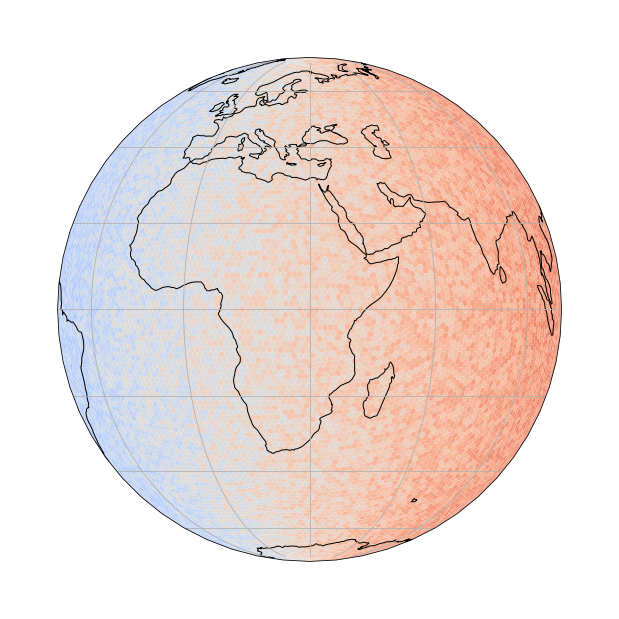

In [178]:
# test geoviews orthographic view
img = earth_polyview.opts(
    projection=ccrs.Orthographic(30, 0), global_extent=False, edgecolor='None',
    xaxis=None, yaxis=None, show_grid=True,
    show_frame=True, colorbar=False, fig_size=300, color='musoil_id_x', cmap='coolwarm' ) * gf.coastline

img

In [119]:
gv.save(img, "isea4_generic_globe.png")

In [18]:
gdf_r3.to_file("/Users/akmoch/dev/build/dggs_t1_presi/isea7h_6_zoom1.gpkg", driver="GPKG")

In [52]:
len(gdf_r3)

23848

In [79]:
import sqlite3

con = sqlite3.connect(hswd_data)
sql = "select ID, MU_GLOBAL, SEQ, ISSOIL, T_OC from HWSD_DATA;"

In [80]:
cur = con.execute(sql)

In [81]:
rs = cur.fetchall()

In [82]:
len(rs)

48148

In [83]:
df_hs = pd.DataFrame(rs).rename(columns={0:'ID', 1:'MU_GLOBAL', 2:'SEQ', 3:'ISSOIL', 4:'T_OC'})
df_hs = df_hs.loc[df_hs['SEQ'] == 1].reset_index(drop=True).copy()
df_hs.head(3)

,ID,MU_GLOBAL,SEQ,ISSOIL,T_OC
0,1,7001,1,0,NaN
1,2,7002,1,0,NaN
2,3,7003,1,0,NaN


In [84]:
df_hs.loc[df_hs['MU_GLOBAL'] == 0]

,ID,MU_GLOBAL,SEQ,ISSOIL,T_OC


In [85]:
len(df_hs)

16327

In [86]:
max(df_hs.index)

16326

In [87]:
df_hs.loc[max(df_hs.index)+1] = (0,0,1,0,0)

In [88]:
# gdf_r3['musoil_id'] = gdf_r3['musoil_id'].astype(np.int64)
gdf_r3['musoil_id'] = gdf_r3['_max'].astype(np.int64)

In [89]:
gdf_r3

,x,y,musoil_id,musoil_id_x,musoil_id_y,musoil_id_xy,_max,geometry,crossed
name,,,,,,,,,
382321,49.704372,34.941009,3508,76.704372,61.941009,111.645381,3508.0,"POLYGON ((49.75478 35.04764, 49.60946 35.02338...",False
382322,49.660082,35.130059,3508,59.660082,45.130059,94.790141,3508.0,"POLYGON ((49.71098 35.23674, 49.56525 35.21241...",False
382665,49.900246,35.071735,3584,84.900246,70.071735,119.971981,3584.0,"POLYGON ((49.95125 35.17831, 49.80560 35.15427...",False
383009,50.097046,35.202178,3584,58.097046,43.202178,93.299224,3584.0,"POLYGON ((50.14868 35.30869, 50.00269 35.28488...",False
383010,50.054571,35.391433,3582,60.054571,45.391433,95.446005,3582.0,"POLYGON ((50.10675 35.49798, 49.96032 35.47410...",False
...,...,...,...,...,...,...,...,...,...
258550,10.322437,35.181123,31969,23.322437,48.181123,58.503560,31969.0,"POLYGON ((10.45460 35.21395, 10.32132 35.28923...",False
258894,10.587667,35.137929,31969,51.587667,76.137929,86.725596,31969.0,"POLYGON ((10.71993 35.16941, 10.58688 35.24599...",False
258893,10.456509,34.997924,31969,33.456509,57.997924,68.454433,31969.0,"POLYGON ((10.58848 35.03012, 10.45556 35.10599...",False


In [90]:
gdf_r3['name'] = gdf_r3.index.values
gdf_r3

,x,y,musoil_id,musoil_id_x,musoil_id_y,musoil_id_xy,_max,geometry,crossed,name
name,,,,,,,,,,
382321,49.704372,34.941009,3508,76.704372,61.941009,111.645381,3508.0,"POLYGON ((49.75478 35.04764, 49.60946 35.02338...",False,382321
382322,49.660082,35.130059,3508,59.660082,45.130059,94.790141,3508.0,"POLYGON ((49.71098 35.23674, 49.56525 35.21241...",False,382322
382665,49.900246,35.071735,3584,84.900246,70.071735,119.971981,3584.0,"POLYGON ((49.95125 35.17831, 49.80560 35.15427...",False,382665
383009,50.097046,35.202178,3584,58.097046,43.202178,93.299224,3584.0,"POLYGON ((50.14868 35.30869, 50.00269 35.28488...",False,383009
383010,50.054571,35.391433,3582,60.054571,45.391433,95.446005,3582.0,"POLYGON ((50.10675 35.49798, 49.96032 35.47410...",False,383010
...,...,...,...,...,...,...,...,...,...,...
258550,10.322437,35.181123,31969,23.322437,48.181123,58.503560,31969.0,"POLYGON ((10.45460 35.21395, 10.32132 35.28923...",False,258550
258894,10.587667,35.137929,31969,51.587667,76.137929,86.725596,31969.0,"POLYGON ((10.71993 35.16941, 10.58688 35.24599...",False,258894
258893,10.456509,34.997924,31969,33.456509,57.997924,68.454433,31969.0,"POLYGON ((10.58848 35.03012, 10.45556 35.10599...",False,258893


In [91]:
gdf_r3_soc = gdf_r3.merge(df_hs, how='left', left_on='musoil_id', right_on='MU_GLOBAL')
# gdf_r3_soc.dropna(subset=['name','MU_GLOBAL'])
gdf_r3_soc

,x,y,musoil_id,musoil_id_x,musoil_id_y,musoil_id_xy,_max,geometry,crossed,name,ID,MU_GLOBAL,SEQ,ISSOIL,T_OC
0,49.704372,34.941009,3508,76.704372,61.941009,111.645381,3508.0,"POLYGON ((49.75478 35.04764, 49.60946 35.02338...",False,382321,41359,3508,1,1,1.40
1,49.660082,35.130059,3508,59.660082,45.130059,94.790141,3508.0,"POLYGON ((49.71098 35.23674, 49.56525 35.21241...",False,382322,41359,3508,1,1,1.40
2,49.900246,35.071735,3584,84.900246,70.071735,119.971981,3584.0,"POLYGON ((49.95125 35.17831, 49.80560 35.15427...",False,382665,41568,3584,1,1,1.13
3,50.097046,35.202178,3584,58.097046,43.202178,93.299224,3584.0,"POLYGON ((50.14868 35.30869, 50.00269 35.28488...",False,383009,41568,3584,1,1,1.13
4,50.054571,35.391433,3582,60.054571,45.391433,95.446005,3582.0,"POLYGON ((50.10675 35.49798, 49.96032 35.47410...",False,383010,41562,3582,1,1,1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21748,10.322437,35.181123,31969,23.322437,48.181123,58.503560,31969.0,"POLYGON ((10.45460 35.21395, 10.32132 35.28923...",False,258550,48002,31969,1,1,3.80
21749,10.587667,35.137929,31969,51.587667,76.137929,86.725596,31969.0,"POLYGON ((10.71993 35.16941, 10.58688 35.24599...",False,258894,48002,31969,1,1,3.80
21750,10.456509,34.997924,31969,33.456509,57.997924,68.454433,31969.0,"POLYGON ((10.58848 35.03012, 10.45556 35.10599...",False,258893,48002,31969,1,1,3.80
21751,10.061450,34.897671,31976,13.061450,37.897671,47.959121,31976.0,"POLYGON ((10.19301 34.93186, 10.06002 35.00580...",False,258548,48013,31976,1,1,1.32


In [92]:
gdf_r3_soc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21753 entries, 0 to 21752
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   x             21753 non-null  float64 
 1   y             21753 non-null  float64 
 2   musoil_id     21753 non-null  int64   
 3   musoil_id_x   21753 non-null  float64 
 4   musoil_id_y   21753 non-null  float64 
 5   musoil_id_xy  21753 non-null  float64 
 6   _max          21753 non-null  float64 
 7   geometry      21753 non-null  geometry
 8   crossed       21753 non-null  bool    
 9   name          21753 non-null  int64   
 10  ID            21753 non-null  int64   
 11  MU_GLOBAL     21753 non-null  int64   
 12  SEQ           21753 non-null  int64   
 13  ISSOIL        21753 non-null  int64   
 14  T_OC          21442 non-null  float64 
dtypes: bool(1), float64(7), geometry(1), int64(6)
memory usage: 2.3 MB


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (musoil_id,T_OC,SEQ,ISSOIL)
   .Coastline.I :Feature   [Longitude,Latitude]
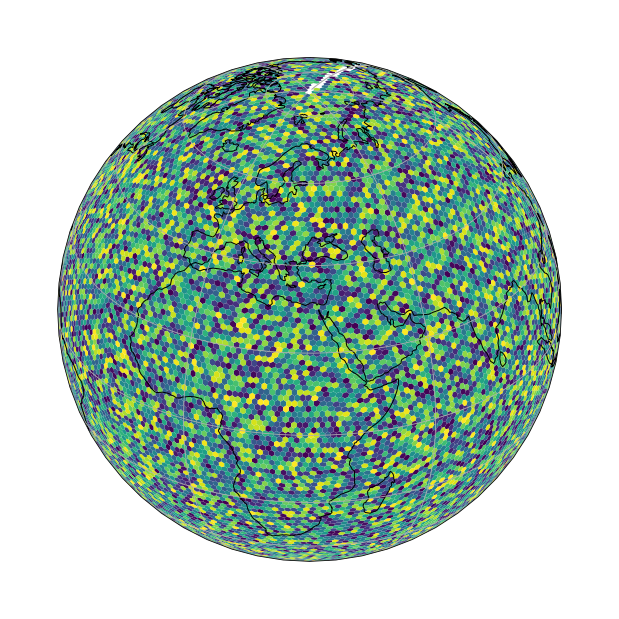

In [218]:

earth_polyview = gv.Polygons(
    gdf_r3_soc, vdims=['musoil_id','T_OC','SEQ', 'ISSOIL']
).opts( projection=ccrs.Orthographic(30, 30) )



# test geoviews orthographic view
img = earth_polyview.opts(
    projection=ccrs.Orthographic(30, 30), global_extent=False, edgecolor='None',
    xaxis=None, yaxis=None, show_grid=True,
    show_frame=True, colorbar=False, fig_size=300, color='musoil_id', cmap='viridis' ) * gf.coastline

img

In [152]:
gv.save(img, "isea4_soilunits_globe.png")

In [96]:
from shapely.geometry import box, Polygon

bb = shapely.geometry.box(19,54,32,60)

In [97]:
gdf_r3_soc_sub1 = gdf_r3_soc[gdf_r3_soc.within(bb)].copy()

:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]   (musoil_id,T_OC,SEQ,ISSOIL,musoil_id_xy)
   .Coastline.I :Feature   [Longitude,Latitude]
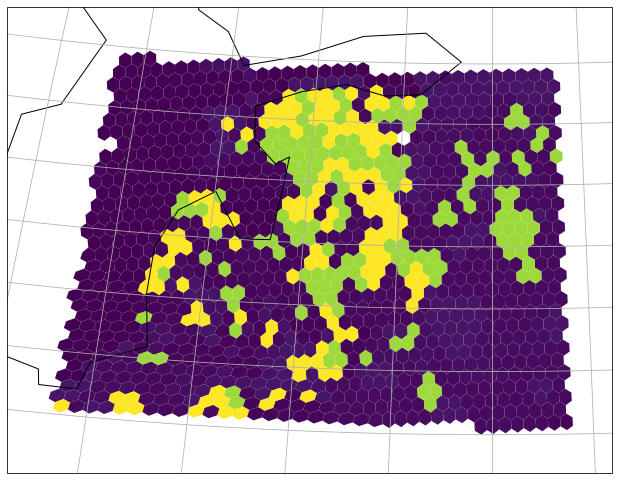

In [103]:

earth_polyview = gv.Polygons(
    gdf_r3_soc_sub1, vdims=['musoil_id','T_OC','SEQ', 'ISSOIL', 'musoil_id_xy']
).opts( projection=ccrs.Orthographic(30, 30) )



# test geoviews orthographic view
img = earth_polyview.opts(
    projection=ccrs.Orthographic(30, 30), global_extent=False, edgecolor='None',
    xaxis=None, yaxis=None, show_grid=True,
    show_frame=True, colorbar=False, fig_size=300, color='T_OC', cmap='viridis' ) * gf.coastline

img

In [104]:
gv.save(img, "isea6_soc_zoom.png")

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd

In [2]:
gdf = gpd.read_file('/Users/akmoch/Nextcloud/shared_work/ut_work/supervision/aleksandra_rammul_dggs_scale_metrics/data/alutag_igeo7_res_9.gpkg')

<Axes: >

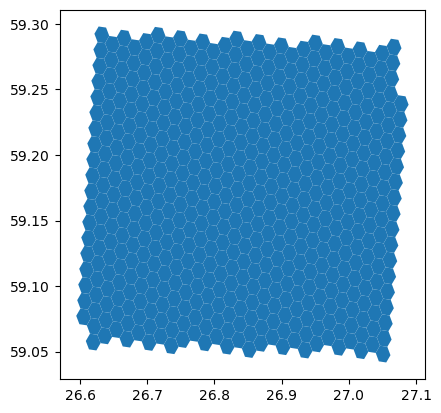

In [3]:
gdf.plot()

In [4]:
gdf.sample()

,name,geometry
498,0042b823ffffffff,"POLYGON ((26.78581 59.09896, 26.77953 59.09341..."


In [5]:
def decode_z7_index(hex_string):
    """
    Decode a Z7 index from a 64-bit unsigned integer (provided as hex string).
    
    Format:
    - First 4 bits: base cell number (0-11)
    - Remaining 60 bits: 20 groups of 3 bits each for resolution digits (0-6, 7 for beyond resolution)
    
    Args:
        hex_string (str): Hexadecimal string representing a 64-bit unsigned integer
        
    Returns:
        tuple: (base_cell, resolution_digits)
            - base_cell: integer 0-11
            - resolution_digits: list of integers (0-6 or 7)
    """
    # Convert hex to binary string, ensuring we have full 64 bits
    binary = bin(int(hex_string, 16))[2:].zfill(64)
    
    # Extract base cell (first 4 bits)
    base_cell = int(binary[:4], 2)
    
    # Extract resolution digits (20 groups of 3 bits each)
    resolution_digits = []
    for i in range(20):  # 60 remaining bits = 20 groups of 3 bits
        start = 4 + (i * 3)  # Start after the first 4 bits
        value = int(binary[start:start + 3], 2)
        if value >= 7:
            continue
        resolution_digits.append(value)
    
    return base_cell, resolution_digits


def analyze_z7_index(hex_string):
    base_cell, resolution_digits = decode_z7_index(hex_string)
    str_rep = [str(base_cell).zfill(2)]
    for i, digit in enumerate(resolution_digits):
        status = False if digit == 7 else True
        # print(f"  Resolution {i}: {digit} ({status})")
        if status:
            str_rep.append(str(digit))
        else:
            continue
    return "".join(str_rep)


def hex_to_int(hex_str):
    # From hex string to integer
    value = int(hex_str, 16)
    return value


def int_to_hex(value):
    # From integer back to hex string, maintaining 16 characters (64 bits)
    hex_back = f"{value:016x}"
    return hex_back


def get_resolution(hex_str):
    base_cell, resolution_digits = decode_z7_index(hex_str)
    return len(resolution_digits)


def get_local_pos(hex_str):
    z7_string = analyze_z7_index(hex_str)
    parent = z7_string[0:-1]
    local_pos = z7_string[-1:]
    is_center = True if local_pos == "0" else False
    return (parent, local_pos, is_center)

In [6]:
hex_str = "0042b853ffffffff"

parent, local_pos, is_center = get_local_pos(hex_str)

z7_string = analyze_z7_index(hex_str)
ref_lev = get_resolution(hex_str)
print(f"{hex_str} -> {z7_string} (res: {ref_lev}) parent: {parent}")

value = hex_to_int(hex_str)
back_hex = int_to_hex(value)
print(f"{hex_str} -> int {value} -> back hex {back_hex}")

print(f"local position: {local_pos} | is_center: {is_center}")

0042b853ffffffff -> 00010256051 (res: 9) parent: 0001025605
0042b853ffffffff -> int 18780019379666943 -> back hex 0042b853ffffffff
local position: 1 | is_center: False


In [7]:
np.uint64(18780019379666943)

18780019379666943

In [8]:
def apply_convert_z7(hex_str):
    z7_string = analyze_z7_index(hex_str)
    z7_int = hex_to_int(hex_str)
    z7_res = get_resolution(hex_str)
    parent, local_pos, is_center = get_local_pos(hex_str)
    return pd.Series([z7_string, np.uint64(z7_int), z7_res, parent, local_pos, is_center])
    
gdf[['z7_string', 'z7_int', 'z7_res', 'parent', 'local_pos', 'is_center' ]] = gdf['name'].apply(apply_convert_z7)

In [9]:
gdf

,name,geometry,z7_string,z7_int,z7_res,parent,local_pos,is_center
0,0042aad3ffffffff,"POLYGON ((27.04625 59.05456, 27.03993 59.04903...",00010252551,18765175972691967,9,0001025255,1,False
1,0042aadbffffffff,"POLYGON ((27.03061 59.06183, 27.0243 59.05629,...",00010252555,18765210332430335,9,0001025255,5,False
2,0042a335ffffffff,"POLYGON ((27.04792 59.06651, 27.04159 59.06097...",00010250632,18756800786464767,9,0001025063,2,False
3,0042a33dffffffff,"POLYGON ((27.03228 59.07377, 27.02595 59.06824...",00010250636,18756835146203135,9,0001025063,6,False
4,0042a331ffffffff,"POLYGON ((27.04959 59.07845, 27.04326 59.07291...",00010250630,18756783606595583,9,0001025063,0,True
...,...,...,...,...,...,...,...,...
546,0042bb6dffffffff,"POLYGON ((26.60058 59.08289, 26.59434 59.07732...",00010256666,18783429583699967,9,0001025666,6,False
547,0042bb65ffffffff,"POLYGON ((26.61632 59.07567, 26.61008 59.0701,...",00010256662,18783395223961599,9,0001025666,2,False
548,0042bb2bffffffff,"POLYGON ((26.64929 59.07317, 26.64304 59.06761...",00010256625,18783146115858431,9,0001025662,5,False
549,0042bb29ffffffff,"POLYGON ((26.63206 59.06844, 26.62582 59.06288...",00010256624,18783137525923839,9,0001025662,4,False


In [68]:
gdf.to_file('/Users/akmoch/Nextcloud/shared_work/ut_work/supervision/aleksandra_rammul_dggs_scale_metrics/data/alutag_igeo7_res_9_details.fgb', driver="Flatgeobuf")

In [10]:
# lower right 0042aad3ffffffff
gdf.explore()

In [11]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   name       551 non-null    object  
 1   geometry   551 non-null    geometry
 2   z7_string  551 non-null    object  
 3   z7_int     551 non-null    uint64  
 4   z7_res     551 non-null    int64   
 5   parent     551 non-null    object  
 6   local_pos  551 non-null    object  
 7   is_center  551 non-null    bool    
dtypes: bool(1), geometry(1), int64(1), object(4), uint64(1)
memory usage: 30.8+ KB


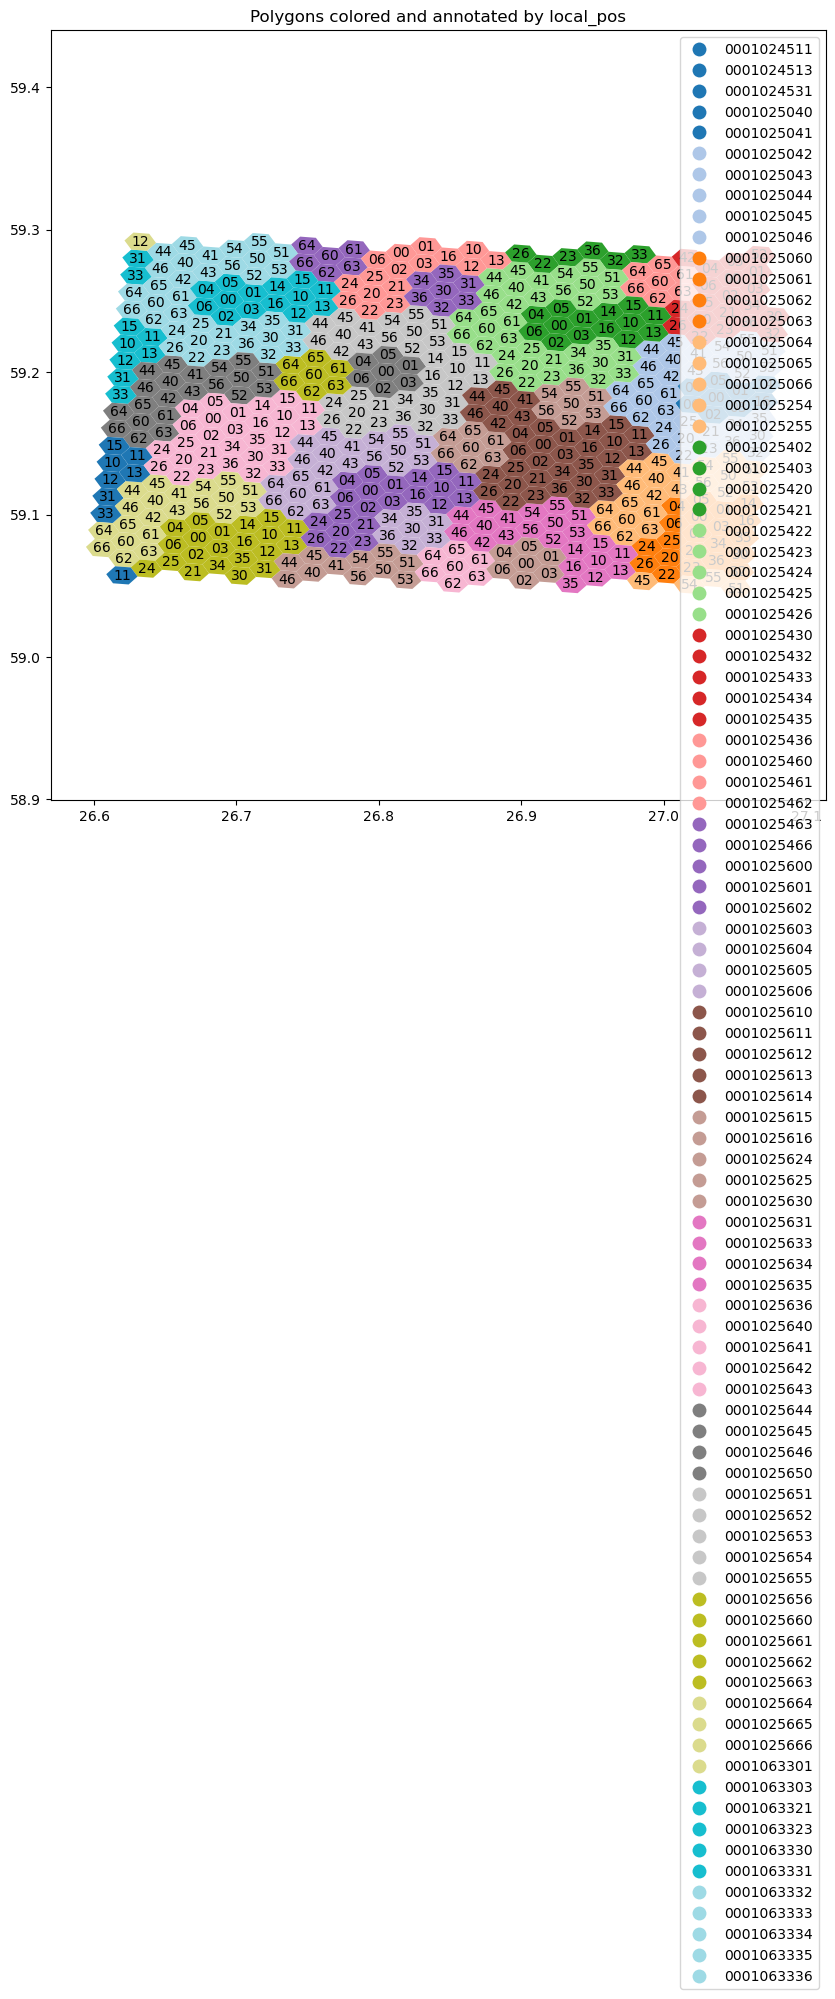

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming you have your GeoDataFrame called 'gdf'
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot polygons colored by local_pos
# gdf.plot(column='local_pos', ax=ax, legend=True, cmap='Pastel1')
gdf.plot(column='parent', ax=ax, legend=True, cmap='tab20')

# Add annotations at the centroid of each polygon
for idx, row in gdf.iterrows():
    # Get the centroid coordinates
    centroid = row.geometry.centroid
    # Add the text annotation
    z7_str = row['z7_string'][-2:]
    ax.annotate(text=z7_str,  # Convert to string for safety
                xy=(centroid.x, centroid.y),  # Position
                horizontalalignment='center',  # Center align text
                verticalalignment='center')    # Center align text

plt.title('Polygons colored and annotated by local_pos')
plt.axis('equal')  # Equal aspect ratio
plt.show()

In [13]:
ntersection_sindex = gdf.sindex
ntersection_sindex

In [14]:
touch_neighbours = ntersection_sindex.query(gdf.geometry, predicate="intersects")

In [15]:
touch_neighbours

array([[  0,   0,   0, ..., 550, 550, 550],
       [  0,   1,   2, ..., 550, 549, 547]])

In [16]:
touch_neighbours.shape

(2, 3583)

In [17]:
touch_neighbours[:,2]

array([0, 2])

In [18]:
np.where(touch_neighbours[1] == 0)

(array([0, 3, 9]),)

In [19]:
gdf.iloc[2]

name                                          0042a335ffffffff
geometry     POLYGON ((27.047917727315216 59.06650675202523...
z7_string                                          00010250632
z7_int                                       18756800786464767
z7_res                                                       9
parent                                              0001025063
local_pos                                                    2
is_center                                                False
Name: 2, dtype: object

In [21]:
def get_neighbours_by_index(gdf_idx, touch_neighbours):
    # Get positions where first row equals 0
    positions_1 = np.where(touch_neighbours[0] == gdf_idx)[0]
    # Get values from second row at those positions
    values_1 = touch_neighbours[1, positions_1]
    # and inverse to be sure
    positions_2 = np.where(touch_neighbours[1] == gdf_idx)[0]
    values_2 = touch_neighbours[1, positions_2]
    return set(values_1.tolist()).union(set(values_2.tolist()))

In [22]:
v = get_neighbours_by_index(gdf_idx=0, touch_neighbours=touch_neighbours)
v

{0, 1, 2}

In [23]:
v - set([0])

{1, 2}

In [25]:
gdf.iloc[list(v)]

,name,geometry,z7_string,z7_int,z7_res,parent,local_pos,is_center
0,0042aad3ffffffff,"POLYGON ((27.04625 59.05456, 27.03993 59.04903...",00010252551,18765175972691967,9,0001025255,1,False
1,0042aadbffffffff,"POLYGON ((27.03061 59.06183, 27.0243 59.05629,...",00010252555,18765210332430335,9,0001025255,5,False
2,0042a335ffffffff,"POLYGON ((27.04792 59.06651, 27.04159 59.06097...",00010250632,18756800786464767,9,0001025063,2,False


In [26]:
def get_neighbours_by_z7(z7_idx, gdf, touch_neighbours, z7_col='name'):
    idx_arr = gdf.loc[gdf[z7_col] == z7_idx].index.tolist()
    if len(idx_arr) <= 0:
        raise ValueError(f"{z7_idx} not in {z7_col}")
    idx = idx_arr[0]
    values_set = get_neighbours_by_index(gdf_idx=idx, touch_neighbours=touch_neighbours)
    values_set = values_set - set([idx])
    neighbour_indices = gdf.iloc[list(values_set)][z7_col].tolist()
    return neighbour_indices
    

In [90]:
n = get_neighbours_by_z7(z7_idx='0042a363ffffffff', gdf=gdf, touch_neighbours=touch_neighbours, z7_col='name')
n 

['0042a309ffffffff',
 '0042a30dffffffff',
 '0042a361ffffffff',
 '0042a367ffffffff',
 '0042a345ffffffff']

In [92]:
b = [ analyze_z7_index(c) for c in n ]
b

['00010250604', '00010250606', '00010250660', '00010250663', '00010250642']

In [95]:
'00010250642' in b

True

In [29]:
gdf.iloc[2]

name                                          0042a335ffffffff
geometry     POLYGON ((27.047917727315216 59.06650675202523...
z7_string                                          00010250632
z7_int                                       18756800786464767
z7_res                                                       9
parent                                              0001025063
local_pos                                                    2
is_center                                                False
Name: 2, dtype: object

In [31]:
n = get_neighbours_by_z7(z7_idx='00010250632', gdf=gdf, touch_neighbours=touch_neighbours, z7_col='z7_string')
n

['00010252551', '00010252555', '00010250636', '00010250630']

In [87]:
n = get_neighbours_by_z7(z7_idx='00010250636', gdf=gdf, touch_neighbours=touch_neighbours, z7_col='z7_string')
n

['00010252555',
 '00010250632',
 '00010250630',
 '00010250634',
 '00010250621',
 '00010250623']

In [ ]:
# filling 2 d array with the local position index of the hexagonal cells
# with i/j for the 2d grid navigation
# i -> x
# j -> y 

# rules to walk to the next index
#  0->1: i-1 and j+1  (R0)
#  1->2: i+2 and j-1  (R1)
#  2->3: i-1 and j+1  (R0)
#  3->4: i   and j-2  (R2)
#  4->5: i-1 and j+1  (R0)
#  5->6: i+2 and j-1  (R1)
#  6->0: i-1 and j+1  (R0) -> plus the i/j 2d grid navigation adjustment of the parent local position k

# number 0-6 are Z7 local positions inside a parent
# 7 is invalid index and is not accessed

#   1, 3
# 5, 0, 2
#   4, 6

# [ 1, 3, 7 ]
# [ 5, 0, 2 ]
# [ 7, 4, 6 ]

# now we want to be able to find all 6 neighbours for any given local position
# the parent grid behaves the same way, but need to be able to detect when we cross into another parent cell

In [350]:
import z7_cell_index_interaction_demo as z7
import copy

class Z7TreeNeighbors:
    def __init__(self, resolution = 0):
        # Define the base neighbor relationships in the hex pattern
        #   1, 3
        #  5, 0, 2
        #   4, 6
        self.resolution = resolution
        
        self.local_neighbors = {
            '0': ['1', '2', '3', '4', '5', '6'],  # Center connects to all
            '1': ['0', '5', '3'],           # Top-left
            '2': ['0', '3', '6'],           # Right
            '3': ['0', '1', '2'],           # Top-right
            '4': ['0', '5', '6'],           # Bottom
            '5': ['0', '1', '4'],           # Left
            '6': ['0', '2', '4']            # Bottom-right
        }
        
        # Define pentagon neighbors (no position 2)
        self.pentagon_neighbors = {
            '0': ['1', '3', '4', '5', '6'],     # Center connects to all except 2
            '1': ['0', '5', '3'],           # Top-left
            '3': ['0', '1'],              # Top-right (no 2 connection)
            '4': ['0', '5', '6'],           # Bottom
            '5': ['0', '1', '4'],           # Left
            '6': ['0', '4']               # Bottom-right (no 2 connection)
        }
        
        # Define the fixed pentagon cells
        self.base_pentagon_cells = {
            '00', '04', '08',
            '01', '05', '09',
            '02', '06', '10',
            '03', '07', '11' }  # Example pentagon indices

        # Base pentagon structure (resolution 0)
        self.base_pentagon_neighbors = {
            '00':  ['01', '02', '03', '04', '05'],
            '01':  ['00', '05', '06', '07', '02'],
            '02':  ['00', '01', '07', '08', '03'],
            '03':  ['00', '02', '08', '09', '04'],
            '04':  ['00', '03', '09', '10', '05'],
            '05':  ['00', '04', '10', '06', '01'],
            '06':  ['01', '05', '10', '11', '07'],
            '07':  ['01', '06', '11', '08', '02'],
            '08':  ['02', '07', '11', '09', '03'],
            '09':  ['03', '08', '11', '10', '04'],
            '10':  ['04', '09', '11', '06', '05'],
            '11':  ['06', '07', '08', '09', '10']
        }

        self.local_pos_neighbourhoods = np.array(
            [['3', '1', '2', '0', '5', '6', '4', '3', '1'],
            ['6', '4', '3', '1', '2', '0', '5', '6', '4'],
            ['0', '5', '6', '4', '3', '1', '2', '0', '5'],
            ['1', '2', '0', '5', '6', '4', '3', '1', '2'],
            ['4', '3', '1', '2', '0', '5', '6', '4', '3'],
            ['5', '6', '4', '3', '1', '2', '0', '5', '6'],
            ['2', '0', '5', '6', '4', '3', '1', '2', '0'],
            ['3', '1', '2', '0', '5', '6', '4', '3', '1'],
            ['6', '4', '3', '1', '2', '0', '5', '6', '4']], dtype='<U1')

        self.parent_neighbourhoods_0 = np.array(
            [['7', '7', '7', '7', '7', '6', '6', '7', '7'],
            ['7', '7', '7', '7', '6', '6', '6', '4', '4'],
            ['7', '7', '2', '2', '6', '6', '4', '4', '4'],
            ['7', '2', '2', '2', '0', '0', '4', '4', '7'],
            ['7', '2', '2', '0', '0', '0', '5', '5', '7'],
            ['7', '3', '3', '0', '0', '5', '5', '5', '7'],
            ['3', '3', '3', '1', '1', '5', '5', '7', '7'],
            ['3', '3', '1', '1', '1', '7', '7', '7', '7'],
            ['7', '7', '1', '1', '7', '7', '7', '7', '7']], dtype='<U1')

        self.parent_neighbourhoods_1 = np.array(
            [['7', '7', '7', '7', '7', '0', '0', '7', '7'],
            ['7', '7', '7', '7', '0', '0', '0', '5', '5'],
            ['7', '7', '3', '3', '0', '0', '5', '5', '5'],
            ['7', '3', '3', '3', '1', '1', '5', '5', '7'],
            ['7', '3', '3', '1', '1', '1', '2', '2', '7'],
            ['7', '6', '6', '1', '1', '2', '2', '2', '7'],
            ['6', '6', '6', '4', '4', '2', '2', '7', '7'],
            ['6', '6', '4', '4', '4', '7', '7', '7', '7'],
            ['7', '7', '4', '4', '7', '7', '7', '7', '7']], dtype='<U1')

        self.parent_neighbourhoods_2 = np.array(
            [['7', '7', '7', '7', '7', '5', '5', '7', '7'],
           ['7', '7', '7', '7', '5', '5', '5', '6', '6'],
           ['7', '7', '1', '1', '5', '5', '6', '6', '6'],
           ['7', '1', '1', '1', '2', '2', '6', '6', '7'],
           ['7', '1', '1', '2', '2', '2', '0', '0', '7'],
           ['7', '4', '4', '2', '2', '0', '0', '0', '7'],
           ['4', '4', '4', '3', '3', '0', '0', '7', '7'],
           ['4', '4', '3', '3', '3', '7', '7', '7', '7'],
           ['7', '7', '3', '3', '7', '7', '7', '7', '7']], dtype='<U1')

        self.parent_neighbourhoods_3 = np.array(
            [['7', '7', '7', '7', '7', '2', '2', '7', '7'],
           ['7', '7', '7', '7', '2', '2', '2', '0', '0'],
           ['7', '7', '4', '4', '2', '2', '0', '0', '0'],
           ['7', '4', '4', '4', '3', '3', '0', '0', '7'],
           ['7', '4', '4', '3', '3', '3', '1', '1', '7'],
           ['7', '5', '5', '3', '3', '1', '1', '1', '7'],
           ['5', '5', '5', '6', '6', '1', '1', '7', '7'],
           ['5', '5', '6', '6', '6', '7', '7', '7', '7'],
           ['7', '7', '6', '6', '7', '7', '7', '7', '7']], dtype='<U1')

        self.parent_neighbourhoods_4 = np.array(
            [['7', '7', '7', '7', '7', '1', '1', '7', '7'],
           ['7', '7', '7', '7', '1', '1', '1', '2', '2'],
           ['7', '7', '6', '6', '1', '1', '2', '2', '2'],
           ['7', '6', '6', '6', '4', '4', '2', '2', '7'],
           ['7', '6', '6', '4', '4', '4', '3', '3', '7'],
           ['7', '0', '0', '4', '4', '3', '3', '3', '7'],
           ['0', '0', '0', '5', '5', '3', '3', '7', '7'],
           ['0', '0', '5', '5', '5', '7', '7', '7', '7'],
           ['7', '7', '5', '5', '7', '7', '7', '7', '7']], dtype='<U1')

        self.parent_neighbourhoods_5 = np.array(
            [['7', '7', '7', '7', '7', '4', '4', '7', '7'],
           ['7', '7', '7', '7', '4', '4', '4', '3', '3'],
           ['7', '7', '0', '0', '4', '4', '3', '3', '3'],
           ['7', '0', '0', '0', '5', '5', '3', '3', '7'],
           ['7', '0', '0', '5', '5', '5', '6', '6', '7'],
           ['7', '1', '1', '5', '5', '6', '6', '6', '7'],
           ['1', '1', '1', '2', '2', '6', '6', '7', '7'],
           ['1', '1', '2', '2', '2', '7', '7', '7', '7'],
           ['7', '7', '2', '2', '7', '7', '7', '7', '7']], dtype='<U1')

        self.parent_neighbourhoods_6 = np.array(
            [['7', '7', '7', '7', '7', '3', '3', '7', '7'],
           ['7', '7', '7', '7', '3', '3', '3', '1', '1'],
           ['7', '7', '5', '5', '3', '3', '1', '1', '1'],
           ['7', '5', '5', '5', '6', '6', '1', '1', '7'],
           ['7', '5', '5', '6', '6', '6', '4', '4', '7'],
           ['7', '2', '2', '6', '6', '4', '4', '4', '7'],
           ['2', '2', '2', '0', '0', '4', '4', '7', '7'],
           ['2', '2', '0', '0', '0', '7', '7', '7', '7'],
           ['7', '7', '0', '0', '7', '7', '7', '7', '7']], dtype='<U1')


        self.centre_coords = (4, 4)

        self.access_mask = {
            '1': (1, 0),  # right position
            '2': (0, -1),  # lower position
            '3': (1, -1),  # lower-right position
            '4': (-1, 1),  # top-Left position 
            '5': (0, 1),  # top position
            '6': (-1, 0) # left position
        }

        self.parent_mask = {
            '1': self.parent_neighbourhoods_1,
            '2': self.parent_neighbourhoods_2,
            '3': self.parent_neighbourhoods_3,
            '4': self.parent_neighbourhoods_4,
            '5': self.parent_neighbourhoods_5,
            '6': self.parent_neighbourhoods_6,
        }

    
    def is_pentagon(self, cell_index):
        """Determine if a cell is a pentagon based on its index"""
        is_top_pent = cell_index in self.base_pentagon_cells
        is_pent_child = set(cell_index[2:]) == set(['0'])
        return is_top_pent or is_pent_child

    
    def get_available_children(self, cell_index):
        """Get available child positions based on whether parent is a pentagon"""
        if self.is_pentagon(cell_index):
            return [ cell_index + c for c in ['0', '1', '3', '4,', '5', '6']]  
        return [ cell_index + c for c in ['0', '1', '2', '3', '4', '5', '6']]



    def patch_parent_cross_neighbour(self, parent_index, parent_pos_val, cross_pos, resolution):
        # parent_index 0001025600
        # the last position (at least), needs to be patched by outside parent_pos_val
        # reconstituated: parent_index(-1) + parent_pos_val + cross_pos
        parent_resolution = resolution - 1
        parent_index_shorter = parent_index[0:-1]
        reconstituated = parent_index_shorter + parent_pos_val + cross_pos
        return reconstituated
        
        
    def get_neighbors(self, cell_index):

        resolution = z7.get_z7string_resolution(cell_index)
        assert(resolution == self.resolution)
        
        parent_index, local_pos, is_center = z7.get_z7string_local_pos(cell_index)
        local_pos = str(local_pos)
        x2_parent, parent_pos, parent_is_center = z7.get_z7string_local_pos(parent_index)
        parent_pos = str(parent_pos)
        
        print(f"cell {cell_index} self_is_pent {self_is_pent} local_pos {local_pos} resolution {resolution} | parent {parent_index} parent_pos {parent_pos} par_is_pent {par_is_pent}")

        neighbors = []

        # Handle resolution 0 (fixed pentagon neighborhood)
        if resolution == 0:
            return self.base_pentagon_neighbors[cell_index]
        
        # Handle resolution 1 (pentagon parents with hex/pent children)
        if resolution == 1:
            if self.is_pentagon(cell_index):
                neighbor_map = [parent_index + n for n in self.pentagon_neighbors[local_pos]]
                neighbors.extend(neighbor_map)
            else:
                neighbor_map = [parent_index + n for n in self.local_neighbors[local_pos]]
                neighbors.extend(neighbor_map)
        
        # easiest, if is_center (same as local_pos == '0')
        if local_pos == '0':
            if self.is_pentagon(cell_index):
                neighbor_map = [parent_index + n for n in self.pentagon_neighbors[local_pos]]
                neighbors.extend(neighbor_map)
            else:
                neighbor_map = [parent_index + n for n in self.local_neighbors[local_pos]]
                neighbors.extend(neighbor_map) 
            
            return neighbors
        
        # Case 2: Cross-boundary neighbors
        if local_pos != '0':

            neighs_pos = []
            all_neighs = ['0', '1', '3', '4,', '5', '6'] if par_is_pent else ['0', '1', '2', '3', '4', '5', '6']
            all_neighs_no_self = list(filter(lambda l: l != local_pos , all_neighs))
            
            # get local neighbours
            if self.is_pentagon(cell_index):
                neighs_pos = self.pentagon_neighbors[local_pos]
            else:
                neighs_pos = self.local_neighbors[local_pos]

            # prepare the easily available local neighbours
            neighbor_map = [parent_index + n for n in neighs_pos]
            neighbors.extend(neighbor_map) 
            
            # filter out the already available local neighbours
            cross_neighs = list(filter(lambda l: l not in neighs_pos , all_neighs_no_self))
            print(f"external neighbours needed: {cross_neighs}")
            
            recentred_coords = copy.copy(self.centre_coords)
            recentred_coords = (
                recentred_coords[0] + self.access_mask[local_pos][0],
                recentred_coords[1] + self.access_mask[local_pos][1])

            all_neighs_no_centre = list(filter(lambda l: l != '0' , all_neighs))
            for cross_pos in cross_neighs:
                # find the grid access coords for the cross pos
                for test_pos in all_neighs_no_centre:
                    access_coords = (
                        recentred_coords[0] + access_mask[test_pos][0],
                        recentred_coords[1] + access_mask[test_pos][1])

                    pos_val = self.local_pos_neighbourhoods[access_coords]
                    
                    if pos_val == cross_pos:
                        # should this be recursive until either base cell resol or
                        # parent_pos is a local '0' ?
                        # as long as we are on a border we have to check if this also a border on the higher level
                        
                        parent_pos_val = self.parent_mask[parent_pos][access_coords]
                        patched_cross_neighbour_index = self.patch_parent_cross_neighbour(
                            parent_index, parent_pos_val, cross_pos, resolution)
                        neighbors.append(patched_cross_neighbour_index)

        return neighbors

    



In [359]:
cell_index = '00010256351'

eventual_neighbours = [
             '00010256132',
             '00010250664',
             '00010250666'
]

parent_index, local_pos, is_center = z7.get_z7string_local_pos(cell_index)
x2_parent_index, parent_pos, parent_is_center = z7.get_z7string_local_pos(parent_index)
res = z7.get_z7string_resolution(cell_index)

tree = Z7TreeNeighbors(resolution=res)

par_is_pent = tree.is_pentagon(parent_index)
self_is_pent = tree.is_pentagon(cell_index)

print(f"cell {cell_index} self_is_pent {self_is_pent} local_pos {local_pos} res {res} | parent {parent_index} parent_pos {parent_pos} par_is_pent {par_is_pent}")


cell 00010256351 self_is_pent False local_pos 1 res 9 | parent 0001025635 parent_pos 5 par_is_pent False


In [ ]:
self.squeeze_ext_cells = {
    # Center is connected only by internal cells
    # an external 1 neighbour cell can only be squeezed from one same parent local pos 6 and 4 cells
    '1': ['6', '4'],     
    '3': ['4', '5'],        
    '2': ['1', '5'],         
    '6': ['3', '1'] 
    '4': ['2', '3'],        
    '5': ['2', '6'],          
      
}

i_cycle = [ '0', '1', '4', '5', '2', '3', '6' ]
j_cycle= [ '0', '5', '6', '4', '3', '1', '2' ]

In [360]:
neighbors = tree.get_neighbors(cell_index)

cell 00010256351 self_is_pent False local_pos 1 resolution 9 | parent 0001025635 parent_pos 5 par_is_pent False
external neighbours needed: ['2', '4', '6']


In [361]:
sorted(neighbors)

['00010256324',
 '00010256326',
 '00010256350',
 '00010256353',
 '00010256355',
 '00010256362']

In [362]:
n = get_neighbours_by_z7(z7_idx=cell_index, gdf=gdf, touch_neighbours=touch_neighbours, z7_col='z7_string')
sorted(n)

['00010250664',
 '00010250666',
 '00010256132',
 '00010256350',
 '00010256353',
 '00010256355']

In [261]:
tree.get_available_children(parent_index)

['00010256000',
 '00010256001',
 '00010256002',
 '00010256003',
 '00010256004',
 '00010256005',
 '00010256006']

In [364]:
res

9

In [374]:
tree8 = Z7TreeNeighbors(resolution=8)
print(tree8.get_neighbors('0001025635'))
print(tree.get_available_children('000102563'))

cell 0001025635 self_is_pent False local_pos 5 resolution 8 | parent 000102563 parent_pos 3 par_is_pent False
external neighbours needed: ['2', '3', '6']
['0001025630', '0001025631', '0001025634', '0001025612', '0001025603', '0001025616']
['0001025630', '0001025631', '0001025632', '0001025633', '0001025634', '0001025635', '0001025636']


In [375]:
tree7 = Z7TreeNeighbors(resolution=7)
print(tree7.get_neighbors('000102563'))
print(tree7.get_available_children('00010256'))

cell 000102563 self_is_pent False local_pos 3 resolution 7 | parent 00010256 parent_pos 6 par_is_pent False
external neighbours needed: ['4', '5', '6']
['000102560', '000102561', '000102562', '000102524', '000102525', '000102506']
['000102560', '000102561', '000102562', '000102563', '000102564', '000102565', '000102566']


In [376]:
tree6 = Z7TreeNeighbors(resolution=6)
print(tree6.get_neighbors('00010256'))
print(tree6.get_available_children('0001025'))

cell 00010256 self_is_pent False local_pos 6 resolution 6 | parent 0001025 parent_pos 5 par_is_pent False
external neighbours needed: ['1', '3', '5']
['00010250', '00010252', '00010254', '00010241', '00010243', '00010205']
['00010250', '00010251', '00010252', '00010253', '00010254', '00010255', '00010256']


In [380]:
import  math
math.pow(7 ,4)

2401.0

In [ ]:
gdf.loc[]

In [293]:
i_cycle = [ '0', '1', '4', '5', '2', '3', '6' ]
j_cycle= [ '0', '5', '6', '4', '3', '1', '2' ]

np.array(i_arr)

access_mask = {
    '1': (1, 0),  # right position
    '2': (0, -1),  # lower position
    '3': (1, -1),  # lower-right position
    '4': (-1, 1),  # top-Left position 
    '5': (0, 1),  # top position
    '6': (-1, 0) # left position
}

In [294]:
import numpy as np

# Define the cycles
i_cycle = ['0', '1', '4', '5', '2', '3', '6']
j_cycle = ['0', '5', '6', '4', '3', '1', '2']

# Create 9x9 array
ijk_arr = np.empty((9, 9), dtype='<U1')

# starts with '3'
lower_left = '3'

start_i = i_cycle.index(lower_left)
start_j = j_cycle.index(lower_left)


In [295]:
# Fill array using the cycles
# Use modulo to cycle through the values
for i in range(9):
    pos_i = ( start_i + i ) % 7
    # print(i_cycle[pos_i])
    
    for j in range(9):
        start_j = j_cycle.index(i_cycle[pos_i])
        pos_j = ( start_j + j ) % 7
        
        # print(j_cycle[pos_j])
        ijk_arr[i,j] = j_cycle[pos_j]


In [296]:
ijk_arr

array([['3', '1', '2', '0', '5', '6', '4', '3', '1'],
       ['6', '4', '3', '1', '2', '0', '5', '6', '4'],
       ['0', '5', '6', '4', '3', '1', '2', '0', '5'],
       ['1', '2', '0', '5', '6', '4', '3', '1', '2'],
       ['4', '3', '1', '2', '0', '5', '6', '4', '3'],
       ['5', '6', '4', '3', '1', '2', '0', '5', '6'],
       ['2', '0', '5', '6', '4', '3', '1', '2', '0'],
       ['3', '1', '2', '0', '5', '6', '4', '3', '1'],
       ['6', '4', '3', '1', '2', '0', '5', '6', '4']], dtype='<U1')

In [308]:
ijk_arr[1,2]

'3'

In [321]:
parent_neighbourhoods = np.array([
       ['7', '7', '7', '7', '7', '6', '6', '7', '7'],
       ['7', '7', '7', '7', '6', '6', '6', '4', '4'],
       ['7', '7', '2', '2', '6', '6', '4', '4', '4'],
       ['7', '2', '2', '2', '0', '0', '4', '4', '7'],
       ['7', '2', '2', '0', '0', '0', '5', '5', '7'],
       ['7', '3', '3', '0', '0', '5', '5', '5', '7'],
       ['3', '3', '3', '1', '1', '5', '5', '7', '7'],
       ['3', '3', '1', '1', '1', '7', '7', '7', '7'],
       ['7', '7', '1', '1', '7', '7', '7', '7', '7']], dtype='<U1')

parent_neighbourhoods

array([['7', '7', '7', '7', '7', '6', '6', '7', '7'],
       ['7', '7', '7', '7', '6', '6', '6', '4', '4'],
       ['7', '7', '2', '2', '6', '6', '4', '4', '4'],
       ['7', '2', '2', '2', '0', '0', '4', '4', '7'],
       ['7', '2', '2', '0', '0', '0', '5', '5', '7'],
       ['7', '3', '3', '0', '0', '5', '5', '5', '7'],
       ['3', '3', '3', '1', '1', '5', '5', '7', '7'],
       ['3', '3', '1', '1', '1', '7', '7', '7', '7'],
       ['7', '7', '1', '1', '7', '7', '7', '7', '7']], dtype='<U1')

In [332]:
def set_everything_8_except_7_and(str_num, array):
    new_array = np.empty_like(array)
    new_array[:] = array
    for i in range(9):
        for j in range(9):
            if new_array[i,j] != str_num and new_array[i,j] != '7':
                new_array[i,j] = '8'
    return new_array


def replace_num_except(str_num_sel, str_num_replace, array):
    new_array = np.empty_like(array)
    new_array[:] = array
    for i in range(9):
        for j in range(9):
            if new_array[i,j] == str_num_sel:
                new_array[i,j] = str_num_replace
    return new_array


def redo_pipeline(str_num_sel, str_num_replace, array):
    arr = set_everything_8_except_7_and(str_num_sel, array)
    arr_out = replace_num_except(str_num_sel, str_num_replace, arr)
    return arr_out


def combine_layers(arr_list):
    start_arr = arr_list[0]
    new_array = np.empty_like(start_arr)
    new_array[:] = start_arr
    for idx in range(1, len(arr_list)):
        work_arr = arr_list[idx]
        for i in range(9):
            for j in range(9):
                if new_array[i,j] != '7' and work_arr[i,j] != '7':
                    if new_array[i,j] == '8' and work_arr[i,j] != '8':
                        new_array[i,j] = work_arr[i,j]
    return new_array

    
redo_pipeline('1', '4', parent_neighbourhoods)
    

array([['7', '7', '7', '7', '7', '8', '8', '7', '7'],
       ['7', '7', '7', '7', '8', '8', '8', '8', '8'],
       ['7', '7', '8', '8', '8', '8', '8', '8', '8'],
       ['7', '8', '8', '8', '8', '8', '8', '8', '7'],
       ['7', '8', '8', '8', '8', '8', '8', '8', '7'],
       ['7', '8', '8', '8', '8', '8', '8', '8', '7'],
       ['8', '8', '8', '4', '4', '8', '8', '7', '7'],
       ['8', '8', '4', '4', '4', '7', '7', '7', '7'],
       ['7', '7', '4', '4', '7', '7', '7', '7', '7']], dtype='<U1')

In [333]:
parent_neighbourhoods

array([['7', '7', '7', '7', '7', '6', '6', '7', '7'],
       ['7', '7', '7', '7', '6', '6', '6', '4', '4'],
       ['7', '7', '2', '2', '6', '6', '4', '4', '4'],
       ['7', '2', '2', '2', '0', '0', '4', '4', '7'],
       ['7', '2', '2', '0', '0', '0', '5', '5', '7'],
       ['7', '3', '3', '0', '0', '5', '5', '5', '7'],
       ['3', '3', '3', '1', '1', '5', '5', '7', '7'],
       ['3', '3', '1', '1', '1', '7', '7', '7', '7'],
       ['7', '7', '1', '1', '7', '7', '7', '7', '7']], dtype='<U1')

In [334]:
i, j = 4, 4

parent_neighbourhoods_dict = {
    '0': parent_neighbourhoods
}

for k_pos in access_mask.keys():
    k = access_mask[k_pos]
    print(f"------ k_pos {k_pos} k {k} ---------" )
    
    x = i + k[0]
    y = j + k[1]
    look_val = ijk_arr[x,y]
    print(f"look_val {look_val}")

    # look around this look_val
    arr_list = []
    for xy_pos in access_mask.keys():
        xy = access_mask[xy_pos]
        # recentre
        ii = x + xy[0]
        jj = y + xy[1]
        look_val_local = ijk_arr[ii,jj]
        print(f"look_val_local {look_val_local} (vs xy_pos {xy_pos})")
        arr = redo_pipeline(xy_pos, look_val_local, parent_neighbourhoods)
        # print(arr)
        arr_list.append(arr)
    new_parent_neighbourhoods = combine_layers(arr_list)
    new_parent_neighbourhoods = replace_num_except('8', k_pos, new_parent_neighbourhoods)
    parent_neighbourhoods_dict.update({k_pos : new_parent_neighbourhoods})
        

------ k_pos 1 k (1, 0) ---------
look_val 1
look_val_local 4 (vs xy_pos 1)
look_val_local 3 (vs xy_pos 2)
look_val_local 6 (vs xy_pos 3)
look_val_local 5 (vs xy_pos 4)
look_val_local 2 (vs xy_pos 5)
look_val_local 0 (vs xy_pos 6)
------ k_pos 2 k (0, -1) ---------
look_val 2
look_val_local 3 (vs xy_pos 1)
look_val_local 1 (vs xy_pos 2)
look_val_local 4 (vs xy_pos 3)
look_val_local 6 (vs xy_pos 4)
look_val_local 0 (vs xy_pos 5)
look_val_local 5 (vs xy_pos 6)
------ k_pos 3 k (1, -1) ---------
look_val 3
look_val_local 6 (vs xy_pos 1)
look_val_local 4 (vs xy_pos 2)
look_val_local 5 (vs xy_pos 3)
look_val_local 0 (vs xy_pos 4)
look_val_local 1 (vs xy_pos 5)
look_val_local 2 (vs xy_pos 6)
------ k_pos 4 k (-1, 1) ---------
look_val 4
look_val_local 5 (vs xy_pos 1)
look_val_local 6 (vs xy_pos 2)
look_val_local 0 (vs xy_pos 3)
look_val_local 2 (vs xy_pos 4)
look_val_local 3 (vs xy_pos 5)
look_val_local 1 (vs xy_pos 6)
------ k_pos 5 k (0, 1) ---------
look_val 5
look_val_local 2 (vs xy_pos 

In [335]:
parent_neighbourhoods_dict['0']

array([['7', '7', '7', '7', '7', '6', '6', '7', '7'],
       ['7', '7', '7', '7', '6', '6', '6', '4', '4'],
       ['7', '7', '2', '2', '6', '6', '4', '4', '4'],
       ['7', '2', '2', '2', '0', '0', '4', '4', '7'],
       ['7', '2', '2', '0', '0', '0', '5', '5', '7'],
       ['7', '3', '3', '0', '0', '5', '5', '5', '7'],
       ['3', '3', '3', '1', '1', '5', '5', '7', '7'],
       ['3', '3', '1', '1', '1', '7', '7', '7', '7'],
       ['7', '7', '1', '1', '7', '7', '7', '7', '7']], dtype='<U1')

In [343]:
parent_neighbourhoods_dict['5']

array([['7', '7', '7', '7', '7', '4', '4', '7', '7'],
       ['7', '7', '7', '7', '4', '4', '4', '3', '3'],
       ['7', '7', '0', '0', '4', '4', '3', '3', '3'],
       ['7', '0', '0', '0', '5', '5', '3', '3', '7'],
       ['7', '0', '0', '5', '5', '5', '6', '6', '7'],
       ['7', '1', '1', '5', '5', '6', '6', '6', '7'],
       ['1', '1', '1', '2', '2', '6', '6', '7', '7'],
       ['1', '1', '2', '2', '2', '7', '7', '7', '7'],
       ['7', '7', '2', '2', '7', '7', '7', '7', '7']], dtype='<U1')

In [344]:
parent_neighbourhoods_dict['6']

array([['7', '7', '7', '7', '7', '3', '3', '7', '7'],
       ['7', '7', '7', '7', '3', '3', '3', '1', '1'],
       ['7', '7', '5', '5', '3', '3', '1', '1', '1'],
       ['7', '5', '5', '5', '6', '6', '1', '1', '7'],
       ['7', '5', '5', '6', '6', '6', '4', '4', '7'],
       ['7', '2', '2', '6', '6', '4', '4', '4', '7'],
       ['2', '2', '2', '0', '0', '4', '4', '7', '7'],
       ['2', '2', '0', '0', '0', '7', '7', '7', '7'],
       ['7', '7', '0', '0', '7', '7', '7', '7', '7']], dtype='<U1')